# Ilia Pakhalko, OSDA Big Hometask

In [73]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [74]:
import lazy_pipeline as lpipe
from importlib import reload

In [114]:
lpipe = reload(lpipe)

Check library versions

In [76]:
from platform import python_version
import sklearn
print(python_version())
print(lpipe.pd.__version__)
print(sklearn.__version__)

3.9.15
1.5.2
1.2.0


Runs seamlessly on
* python = 3.9.13, 
* pandas = 1.5.1
* scikit-learn = 1.1.3

# Prepare the data

Load data

In [82]:
# for illustrative purposes
df = lpipe.load_data('cancer')
df.head()

,Clump_Thickness,Uniformity_of_Cell_Size,Uniformity_of_Cell_Shape,Marginal_Adhesion,Single_Epithelial_Cell_Size,Bare_Nuclei,Bland_Chromatin,Normal_Nucleoli,Mitoses,Class
0,5,1,1,1,2,1,3,1,1,False
1,5,4,4,5,7,10,3,2,1,False
2,3,1,1,1,2,2,3,1,1,False
3,6,8,8,1,3,4,3,7,1,False
4,4,1,1,3,2,1,3,1,1,False


In [83]:
y_name = 'Class'
X = lpipe.binarize_X(df.drop(y_name, axis=1), bin_counts=3)
X.head()

,Clump_Thickness: 0,Clump_Thickness: 1,Clump_Thickness: 2,Uniformity_of_Cell_Size: 0,Uniformity_of_Cell_Size: 1,Uniformity_of_Cell_Size: 2,Uniformity_of_Cell_Shape: 0,Uniformity_of_Cell_Shape: 1,Uniformity_of_Cell_Shape: 2,Marginal_Adhesion: 0,...,Bare_Nuclei: 2,Bland_Chromatin: 0,Bland_Chromatin: 1,Bland_Chromatin: 2,Normal_Nucleoli: 0,Normal_Nucleoli: 1,Normal_Nucleoli: 2,Mitoses: 0,Mitoses: 1,Mitoses: 2
0,False,True,False,True,False,False,True,False,False,True,...,False,True,False,False,True,False,False,True,False,False
1,False,True,False,False,True,False,False,True,False,False,...,True,True,False,False,True,False,False,True,False,False
2,True,False,False,True,False,False,True,False,False,True,...,False,True,False,False,True,False,False,True,False,False
3,False,True,False,False,False,True,False,False,True,True,...,False,True,False,False,False,True,False,True,False,False
4,False,True,False,True,False,False,True,False,False,True,...,False,True,False,False,True,False,False,True,False,False


In [115]:
def prepare_data(bin_counts = None):
    """
    prepares data to run and evaluate lazy fca algorithm.
    :param bin_counts: number of bins to binarize columns. Can be set to columns individually
    via dict, or broadcasted onto all of them when specified as an int.
    :return:
    """
    df = lpipe.load_data('cancer')
    y_name = 'Class'
    y = df[y_name]
    X = lpipe.binarize_X(df.drop(y_name, axis=1), bin_counts)
    X = X.sample(frac=1, random_state=42)  # Shuffle X
    y = y[X.index].values.tolist()  # Order y to follow the order of rows from X
    X_bin = [set(X.columns[x]) for idx, x in X.iterrows()]
    n_train = int(len(X) * 0.1)
    n_test = len(X) - n_train
    y_test = y[n_train:]

    return X_bin, y, n_train, n_test, y_test

# Make predictions

Make predictions and measure time required to obtain these predictions

The dataset is somewhat balanced, thus, both accuracy and F-measure seem to be sensible in this context.

In [116]:
mc_grid = [1, 5, 20, 50, 70]

In [117]:
from sklearn.metrics import accuracy_score, f1_score

def run_and_score(X_bin, n_train, y, y_test):
    score_vals = {}
    all_y_preds, all_t_preds = [], []
    all_y_preds_fixedtrain, all_t_preds_fixedtrain = [], []
    for min_cardinality in mc_grid:
        gen = lpipe.predict_array(X_bin, y, n_train, use_tqdm=True)
        y_preds, t_preds = lpipe.apply_stopwatch(gen)
        all_y_preds.append(y_preds)
        all_t_preds.append(t_preds)

        gen = list(lpipe.predict_array(X_bin, y, n_train, use_tqdm=True, update_train=False))
        y_preds_fixedtrain, t_preds_fixedtrain = lpipe.apply_stopwatch(gen)
        all_y_preds_fixedtrain.append(y_preds_fixedtrain)
        all_t_preds_fixedtrain.append(t_preds_fixedtrain)

        # we will ignore the warnings, as they are due to the first pair of predictions
        # being False, False for both ground truth and y_preds (y_preds_fixedtrain)

        for score_f in [accuracy_score, f1_score]:
            score_name = score_f.__name__ + f'_mc={min_cardinality}'
            preds = y_preds
            score_vals[score_name] = [score_f(y_test[:i], preds[:i]) for i in range(1, len(preds))]

            score_name = score_f.__name__ + '_fixedtrain' + f'_mc={min_cardinality}'
            preds = y_preds_fixedtrain
            score_vals[score_name] = [score_f(y_test[:i], preds[:i]) for i in range(1, len(preds))]

    return score_vals, all_y_preds, all_t_preds, all_y_preds_fixedtrain, all_t_preds_fixedtrain

# Analyze results

In [118]:
import matplotlib.pyplot as plt

def plot_scores(n_train, score_vals, all_y_preds, all_t_preds, all_y_preds_fixedtrain, all_t_preds_fixedtrain) -> None:
    plt.rcParams['figure.facecolor'] = (1,1,1,1)  # Replace default "transparent" background of the figure with the "white" one

    fig, axs = plt.subplots(2, 2, figsize=(12, 8))

    # First two plots are for prediction quality comparison
    for ax_idx, metric_name in zip([0, 1],['accuracy_score', 'f1_score']):
        axs[0][ax_idx].set_ylim(0-0.05, 1+0.05)
        for idx, mc in enumerate(mc_grid):
            axs[0][ax_idx].plot(range(n_train+1, len(X)),
                    score_vals[metric_name+f'_mc={mc}'],
                    label=f'mc={mc}'
            )
            axs[0][ax_idx].plot(range(n_train+1, len(X)),
                    score_vals[metric_name+'_fixedtrain'+f'_mc={mc}'],
                    label=f'mc={mc} (fixed train)'
            )

            # for debug purposes
            # axs[0][ax_idx].plot(range(n_train+1, len(X)),
            #         [1 / mc] * (len(X) - (n_train+1)),
            #         label=f'1/mc={1/mc}'
            # )

    # The third plot is for prediction speed comparison
    for idx, mc in enumerate(mc_grid):
        axs[1,0].plot(range(n_train, len(X)), all_t_preds[idx], label=f'mc={mc}')
        axs[1,0].plot(range(n_train, len(X)), all_t_preds_fixedtrain[idx], label=f'mc={mc} (fixed train)')

    # Add labels and titles to the plots
    for (ax, t_verb, dim) in zip(axs.flatten(), ['Accuracy score', 'F1 score', 'Prediction time'], ['','','(secs.)']):
        ax.set_title('\n'.join([f"{t_verb} progression", "w.r.t. the number of train examples"]), loc='left', size=18)
        ax.set_xlabel('# of train examples', loc='right', size=14)
        ax.set_ylabel(f"{t_verb} {dim}".strip(), loc='top', size=14)
        ax.legend()

    # Drop the predefined fourth plot since we do not use it
    axs[1,1].set_axis_off()

    # Some postprocessing of plots
    plt.tight_layout()
    plt.subplots_adjust()

    plt.savefig('Classifier_comparison.png')
    plt.show()

Predicting step by step: 100%|██████████| 699/699 [00:00<00:00, 2918.28it/s]
/Users/i-pakhalko/PycharmProjects/MLNikolenko/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/i-pakhalko/PycharmProjects/MLNikolenko/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
Predicting step by step: 100%|██████████| 699/699 [00:00<00:00, 2960.62it/s]
/Users/i-pakhalko/PycharmProjects/MLNikolenko/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWar

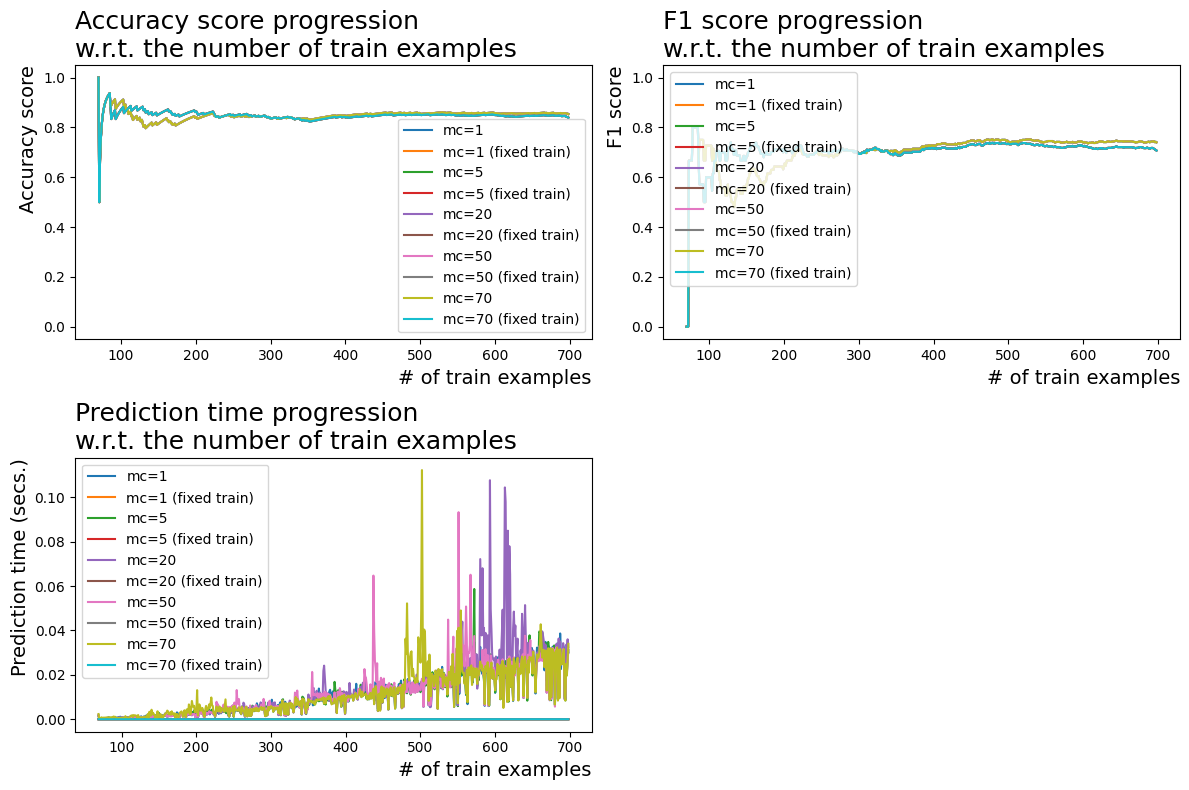

In [113]:
%time
# first run on regular number of bins:

X_bin, y, n_train, n_test, y_test = prepare_data()
score_vals, all_y_preds, all_t_preds, all_y_preds_fixedtrain, all_t_preds_fixedtrain = run_and_score(X_bin, n_train, y, y_test)
plot_scores(n_train, score_vals, all_y_preds, all_t_preds, all_y_preds_fixedtrain, all_t_preds_fixedtrain)

Predicting step by step: 100%|██████████| 699/699 [00:00<00:00, 2305.15it/s]
/Users/i-pakhalko/PycharmProjects/MLNikolenko/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/i-pakhalko/PycharmProjects/MLNikolenko/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
Predicting step by step: 100%|██████████| 699/699 [00:00<00:00, 2301.41it/s]
/Users/i-pakhalko/PycharmProjects/MLNikolenko/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWar

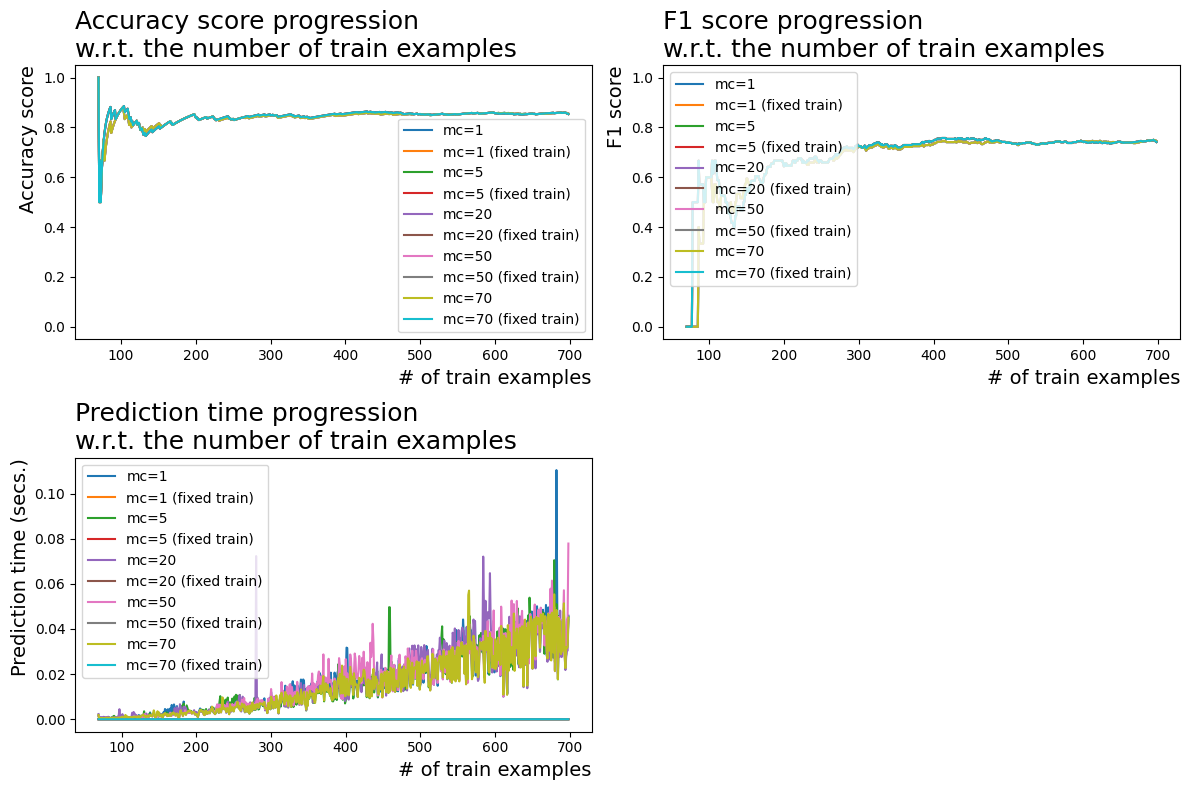

In [119]:
%time
# then reduce number of bins to 3:

X_bin, y, n_train, n_test, y_test = prepare_data(bin_counts=3)
score_vals, all_y_preds, all_t_preds, all_y_preds_fixedtrain, all_t_preds_fixedtrain = run_and_score(X_bin, n_train, y, y_test)
plot_scores(n_train, score_vals, all_y_preds, all_t_preds, all_y_preds_fixedtrain, all_t_preds_fixedtrain)

In conclusion:

We clearly see, that lowering the number of bins from 10 to 3 for each category for the procedure of binarization significantly hurts quality in the first stages of learning process, when the initial number of train examples is low. The minimal cardinality doesn't seem to affect our prediction quality in any significant way. Regarding the prediction time progression, the only difference that I can think of is the obvious one, between fixed train sample and a dynamically updated one; I'm inclined to attrinute other discrepancies to noise.